In [28]:
# notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# internal imports
from warm_start_hmpc.controller import HybridModelPredictiveController
from mld_dynamics_complementarity import CartPoleWithWalls
from warm_start_hmpc.mcais import mcais, solve_dare

In [36]:
# cart-pole system with MLD dynamics
cp = CartPoleWithWalls()

# hybrid controller
T = 20

# weight matrices
C = np.diag(np.reciprocal(cp.x_max)) * cp.h
D = np.array([[np.reciprocal(cp.fc_max)]]).T * cp.h

# LQR cost to go
P, K = solve_dare(cp.mld.A, cp.mld.B[:,:1], C.dot(C), D.dot(D))
C_T = np.linalg.cholesky(P).T
D = np.hstack((D, np.zeros((1, cp.mld.nu-1))))
objective = [C, D, C_T]

# mcais terminal set
A_cl = cp.mld.A + cp.mld.B[:,:1].dot(K)
lhs_cl = cp.mld.F + cp.mld.G[:,:1].dot(K)
terminal_set = mcais(A_cl, lhs_cl, cp.mld.h, verbose=True)

controller = HybridModelPredictiveController(
    cp.mld,
    T,
    objective,
    terminal_set
)

# initial push towards the right wall
x0 = np.array([0., 0., 1., 0.])
# x0 = np.array([0., 0., 0., .5])

Time horizon: 16. Convergence index: 0.000000. Number of facets: 102.
Maximal constraint-admissible invariant set found. Removing redundant facets ... minimal facets are 62.


## Open-loop solution

In [37]:
# solve in open loop
solution, leaves = controller.feedforward(
    x0,
#     draw_label='Cart pole with walls'
)

|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.06            1               4.664e-02       inf             
                 3.11            54              6.516e-02       inf             
                 6.11            107             6.570e-02       inf             
 New incumbent   8.95            160             6.913e-02       6.913e-02       
 Solution found  8.95            160             6.913e-02       6.913e-02       

Explored 160 nodes in 8.949 seconds: optimal solution found with cost 6.913e-02.


<IPython.core.display.Javascript object>


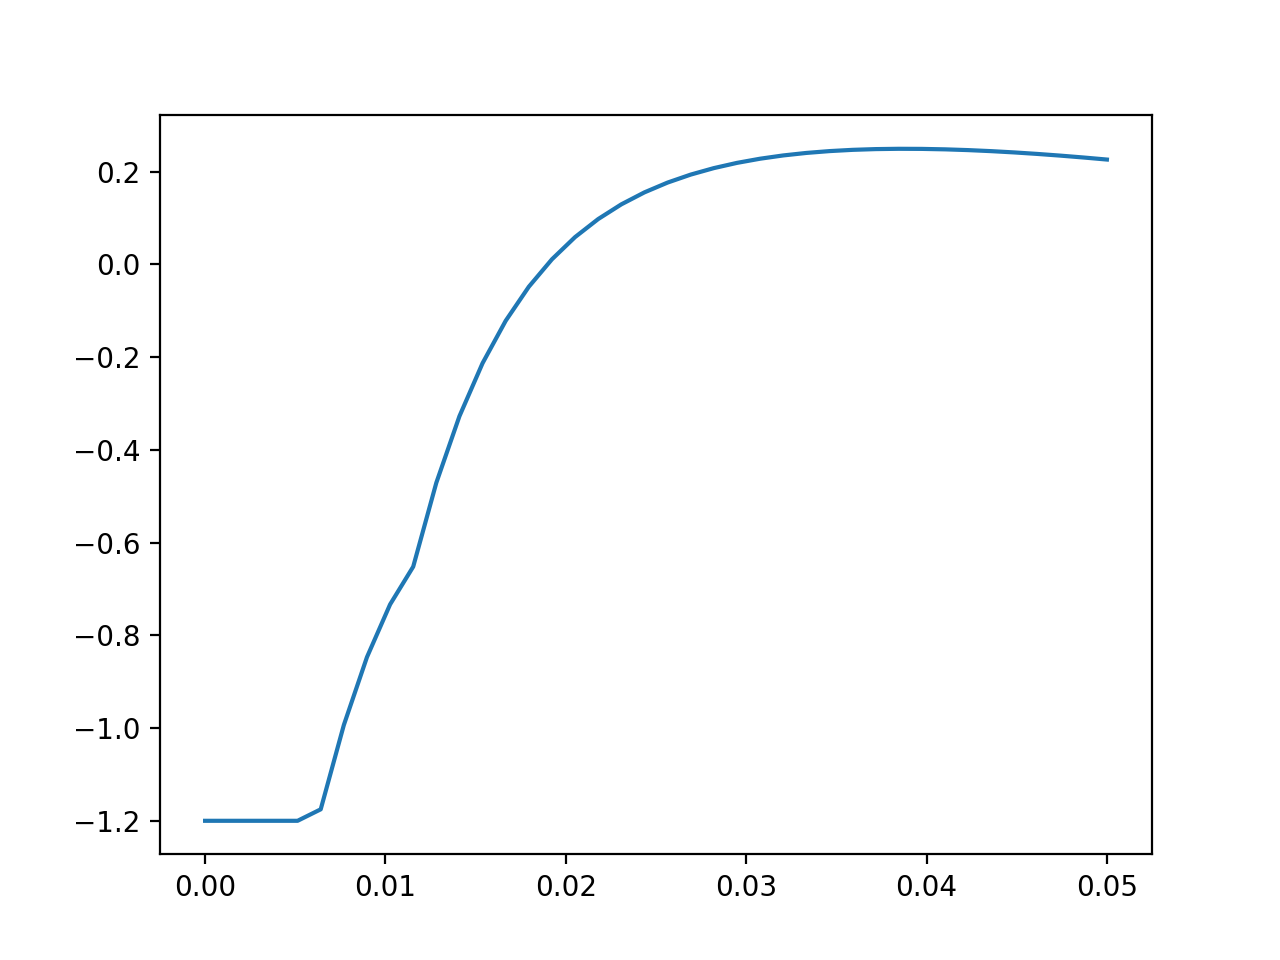

In [38]:
plt.plot(
    np.linspace(0,cp.h,T),
    [ut[0] for ut in solution.variables['uc']],
)

In [35]:
x_gurobi, obj_gurobi = controller.feedforward_gurobi(x0)

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Optimize a model with 746 rows, 184 columns and 2200 nonzeros
Model has 110 quadratic objective terms
Variable types: 144 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [6e-05, 6e+01]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+00]
Presolve removed 544 rows and 58 columns
Presolve time: 0.01s
Presolved: 202 rows, 126 columns, 981 nonzeros
Presolved model has 106 quadratic objective terms
Variable types: 113 continuous, 13 integer (13 binary)

Root relaxation: objective 6.443772e-02, 285 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.06444    0    7          -    0.06444      -     -    0s
     0     0    0.06503    0    7          -    0.06503

In [39]:
from visualizer import vis, animate
vis.jupyter_cell()

In [40]:
animate(solution.variables['x'], cp.h)
# animate(x_gurobi, h_nom)

## Solve in closed loop

In [24]:
from visualizer import vis, visualize
vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [25]:
# set up simulation
T_sim = 3*T
x_true = [x0]
x_predicted = []
x_sim = []
u_sim = []
e_sim = []
V_sim = []
warm_start = None

for t in range(T_sim):
    print('Time step %d.'%t)#, end='\r')
    
    # solve miqp
    solution, leaves = controller.feedforward(
        cp.project_in_feasible_set(x_true[-1]),
        warm_start=warm_start,
        printing_period=20.
    )
    
    # reorganize solution
    uc0 = solution.variables['uc'][0]
    ub0 = solution.variables['ub'][0]
    u0 = np.concatenate((uc0, ub0))
    x_sim_t = cp.simulate(x_true[-1], uc0[0:1], cp.h)[0]
    x1 = x_sim_t[-1]
    e0 = x1 - cp.mld.A.dot(x_true[-1]) - cp.mld.B.dot(u0)
    print('predicted state:', solution.variables['x'][1])
    print('true state:', x1)
    print('modeling error:', e0)
    visualize(x1)
    
    # generate warm start
    warm_start = controller.construct_warm_start(
        leaves,
        cp.project_in_feasible_set(x_true[-1]),
        uc0,
        ub0,
        e0
    )
    
    # retrieve closed-loop trajectory
    x_predicted.append(solution.variables['x'][1])
    x_true.append(x1)
    x_sim.extend(x_sim_t)
    u_sim.append(uc0)
    e_sim.append(e0)
    V_sim.append(solution.objective)

Time step 0.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 Root node       0.04            1               4.862e-02       inf             
 New incumbent   2.48            80              6.913e-02       6.913e-02       
 Solution found  2.51            81              6.913e-02       6.913e-02       

Explored 81 nodes in 2.513 seconds: optimal solution found with cost 6.913e-02.
predicted state: [ 0.047 -0.003  0.94  -0.06 ]
true state: [ 0.04846675 -0.00153651  0.93974956 -0.06050095]
modeling error: [ 0.00146675  0.00146349 -0.00025044 -0.00050095]
Time step 1.
Loaded warm start with 39 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.22            6               6.494e-02       6.494e-02 

 New incumbent   0.31            11              3.042e-02       3.085e-02       
 Solution found  0.37            13              3.085e-02       3.085e-02       

Explored 13 nodes in 0.370 seconds: optimal solution found with cost 3.085e-02.
predicted state: [ 0.31878995 -0.09443902  0.02630849  0.4135604 ]
true state: [ 0.31924391 -0.09247377  0.03349031  0.42653561]
modeling error: [0.00045396 0.00196524 0.00718182 0.01297521]
Time step 13.
Loaded warm start with 42 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.28            10              2.549e-02       2.553e-02       
 Solution found  0.31            11              2.553e-02       2.553e-02       

Explored 11 nodes in 0.311 seconds: optimal solution found with cost 2.553e-02.
predicted state: [ 0.31960025 -0.07477701  0.00712688  0.3539353 ]
true

Time step 25.
Loaded warm start with 42 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.17            6               1.047e-02       1.047e-02       
 Solution found  0.17            6               1.047e-02       1.047e-02       

Explored 6 nodes in 0.167 seconds: optimal solution found with cost 1.047e-02.
predicted state: [ 0.23139247 -0.00652527 -0.23597028 -0.01156126]
true state: [ 0.23144068 -0.00640585 -0.23607161 -0.01176405]
modeling error: [ 4.82054104e-05  1.19420432e-04 -1.01330969e-04 -2.02786803e-04]
Time step 26.
Loaded warm start with 42 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.17            6               

 New incumbent   0.17            6               3.887e-03       3.887e-03       
 Solution found  0.17            6               3.887e-03       3.887e-03       

Explored 6 nodes in 0.166 seconds: optimal solution found with cost 3.887e-03.
predicted state: [ 0.10750115 -0.0124338  -0.16331417 -0.00045288]
true state: [ 0.10731043 -0.01247284 -0.16333302 -0.00049046]
modeling error: [-1.90723514e-04 -3.90344405e-05 -1.88446514e-05 -3.75721079e-05]
Time step 38.
Loaded warm start with 39 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.17            6               3.539e-03       3.539e-03       
 Solution found  0.17            6               3.539e-03       3.539e-03       

Explored 6 nodes in 0.168 seconds: optimal solution found with cost 3.539e-03.
predicted state: [ 0.09952227 -0.01243069 -0.15576318

 New incumbent   0.18            6               1.251e-03       1.251e-03       
 Solution found  0.18            6               1.251e-03       1.251e-03       

Explored 6 nodes in 0.184 seconds: optimal solution found with cost 1.251e-03.
predicted state: [ 0.03382054 -0.00997134 -0.08761613  0.00597845]
true state: [ 0.03369816 -0.00996666 -0.08754204  0.00612662]
modeling error: [-1.22381451e-04  4.68663607e-06  7.40938843e-05  1.48172089e-04]
Time step 50.
Loaded warm start with 39 nodes. Lower bound from warm start is 0.000.
|    Updates    |    Time (s)   |  Solved nodes |  Lower bound  |  Upper bound  |
 --------------- --------------- --------------- --------------- ---------------
 New incumbent   0.19            6               1.142e-03       1.142e-03       
 Solution found  0.19            6               1.142e-03       1.142e-03       

Explored 6 nodes in 0.192 seconds: optimal solution found with cost 1.142e-03.
predicted state: [ 0.02956399 -0.00966656 -0.08268332

<IPython.core.display.Javascript object>


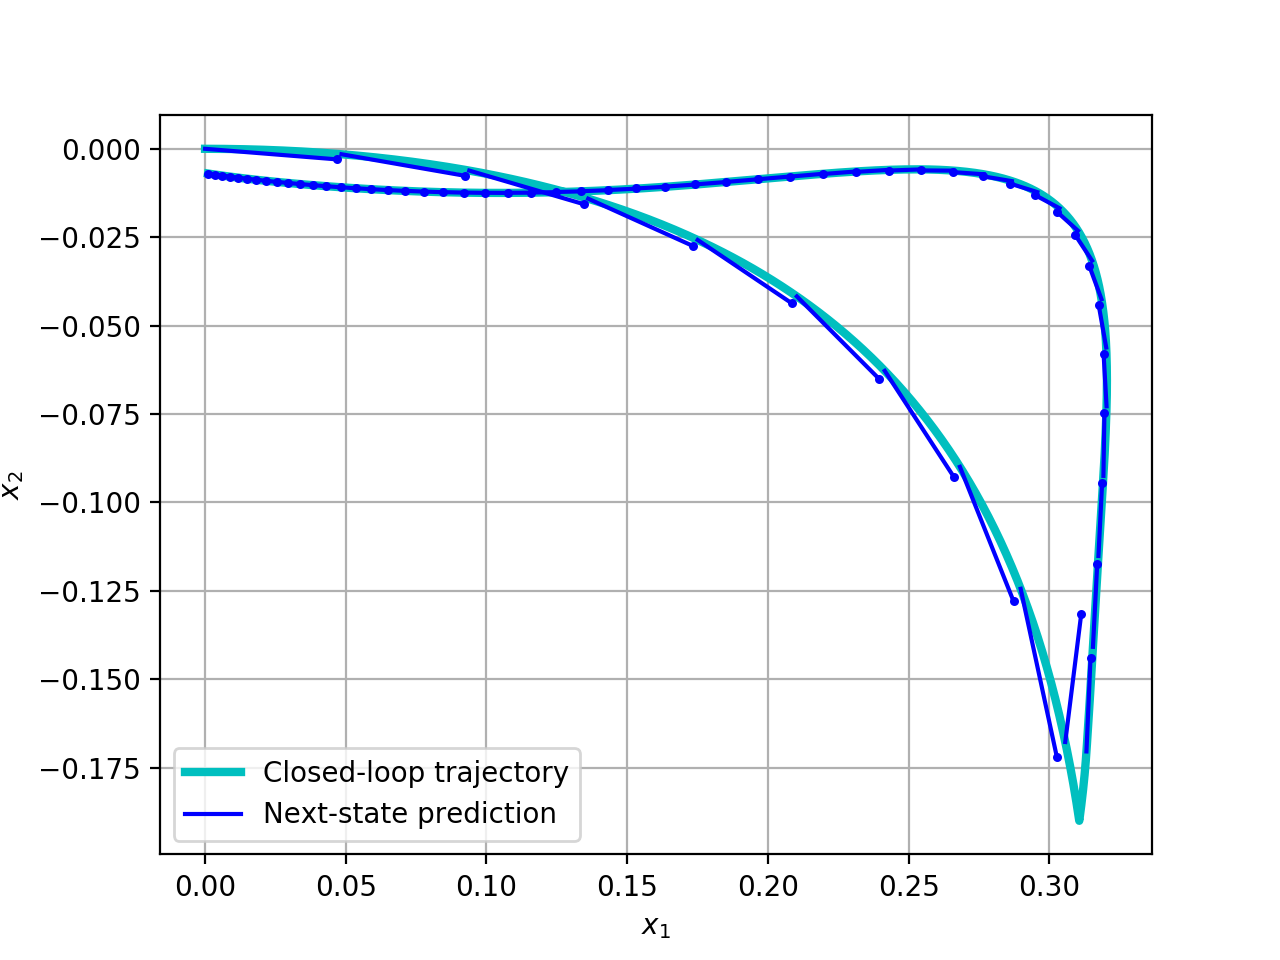

In [26]:


indices =  [0,1]

fig = plt.figure()

plt.plot(
    [xt[indices[0]] for xt in x_sim],
    [xt[indices[1]] for xt in x_sim],
    color='c',
    label='Closed-loop trajectory',
    linewidth=3
)

for t in range(T_sim):
    label = 'Next-state prediction'
    if t > 0:
        label=None
    plt.plot(
        [x_true[t][indices[0]], x_predicted[t][indices[0]]],
        [x_true[t][indices[1]], x_predicted[t][indices[1]]],
        c='b',
        label=label
    )
    plt.scatter(
        [x_predicted[t][indices[0]]],
        [x_predicted[t][indices[1]]],
        c='b',
        marker='o',
        s=5,
        zorder=3
    )
# plt.plot([0.], [0.], c='b', marker='o', markersize=5, label='Prediction')

#     marker='o',
#     markersize=12,
#     markerfacecolor='w',
    

#     arrow = plt.arrow(
#         x_true[t][0],
#         x_true[t][1],
#         x_predicted[t][0]-x_true[t][0],
#         x_predicted[t][1]-x_true[t][1],
#         length_includes_head=True,
#         fc='k',
#         ec='k'
#     )
    
        
# for t, xt in enumerate(x_true):
#     plt.text(
#         xt[0],
#         xt[1],
#         r'$%d$'%t,
#         horizontalalignment='center',
#         verticalalignment='center',
#         fontsize=7
#     )
plt.xlabel(r'$x_%d$'%(indices[0]+1))
plt.ylabel(r'$x_%d$'%(indices[1]+1))
# ax.set_zlabel(r'Solved QPs')
plt.legend()
plt.grid(True)
plt.show()

## Animation

In [ ]:
from visualizer import vis, animate
vis.jupyter_cell()

In [ ]:
x0 = np.array([0, 0, 1, 0])
u0 = np.zeros(1)
dt = 5
x_sim, h = cp.simulate(x0, u0, dt)
animate(x_sim, h)